In [25]:
import glob
import matplotlib.pyplot as plt
import math
import statistics as st
import random
import time
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Noise addition functions: 
* Salt and pepper noise of user-specified strength 
* Gaussian noise of user-specified parameters

In [26]:
def salt_n_pepper(img, prob):
    # prob should be int [0 - 1], recommend <.1
    new_img = []
    for i in range(len(img)):
        new_img.append([])
        for j in range(len(img[i])):
            if random.random() <= prob:
                if random.choice(["black", "white"]) == "black":
                    new_img[i].append(0)
                else:
                    new_img[i].append(255)
            else:
                new_img[i].append(img[i][j])
    return new_img
    

In [27]:
def gaussian_noise(img, mu=0, sigma=1):
    new_img = []
    for i in range(len(img)):
        new_img.append([])
        for j in range(len(img[i])):
            new_val = img[i][j] + random.gauss(mu, sigma)
            if new_val < 0:
                new_img[i].append(0)
            elif new_val > 255:
                new_img[i].append(1)
            else:
                new_img[i].append(new_val)

    return new_img

Converting color images to selected single color spectrum. 

In [28]:
def grayscale(img):
    new_img = []
    for i in range(len(img)):
        new_img.append([])
        for j in range(len(img[i])):
            # CIE recommended constants
            grey = .2126 * img[i][j][0] + .7152 * img[i][j][1]+ .0722 * img[i][j][2]
            new_img[i].append(grey)
    return new_img

open_in_gray is the only function to open an image as all other functions are for grayscale images. run open_in gray on a file, then a function or functions on the returned image, then to_image on that return to get a viewable image

In [29]:
def open_in_gray(file):
    img = Image.open(file)
    width, height = img.size
    pix = img.getdata()
    pix_list = []
    for y in range(height):
        pix_list.append([pix[y * width + x] for x in range(width)])

    # all functions are on grayscale, so this step is required
    pix_list = grayscale(pix_list)
    return pix_list

In [30]:
def to_image(pix_list, save_loc=None):
    size = [len(pix_list[0]), len(pix_list)]
    flat_list = []
    for row in pix_list:
        for pixel in row:
            flat_list.append(pixel)
    output = Image.new("L", size)
    output.putdata(flat_list)
    
    if save_loc:
        output.save(f"{save_loc}")
    return output

Histogram calculation for each individual image

In [31]:
def hist(img, bins=255):
    bin_divs = []
    counts = []
    for i in range(1, bins + 1):
        bin_divs.append(i * 255/bins)
        counts.append(0)

    for i in range(len(img)):
        for j in range(len(img[i])):
            # better as a binary search
            for k in range(bins):
                if img[i][j] <= bin_divs[k]:
                    counts[k] += 1
                    break
    
    return bin_divs, counts

In [32]:
def plot_hist(bin_divs, counts, title=None):
    half_width = bin_divs[0]/2
    plt.bar([x - half_width for x in bin_divs], counts, width = half_width*2)
    plt.xlabel("intensity")
    plt.ylabel("count")
    if title:
            titles = {"cyl": "columnar epithelial",
                    "para": "parabasal squamous epithelial",
                    "inter": "intermediate squamous epithelial",
                    "super": "superficial squamous epithelial",
                    "let": "mild nonkeratinizing dysplastic",
                    "mod": "moderate nonkeratinizing dysplastic",
                    "svar": "severe nonkeratinizing dysplastic"}
            plt.title(titles[title])
    plt.show()

Averaged histograms of pixel values for each class of images

hist_avg_class can be run independently of open_in_gray as it runs it internally

In [33]:
def hist_avg_class(folder, abbr, bins=255, plot=False):
    # abbr can be:
    # "cyl": columnar epithelial?
    # "para": parabasal squamous epithelial
    # "inter": intermediate squamous epithelial
    # "super": superficial squamous epithelial
    # "let": mild nonkeratinizing dysplastic?
    # "mod": moderate nonkeratinizing dysplastic
    # "svar": severe nonkeratinizing dysplastic?
    files = glob.glob(f"{folder}/{abbr}*")

    bin_divs = [i * 255/bins for i in range(1, bins + 1)]
    counts = [0 for _ in range(bins)]
    # open and grayscale each file
    for file in files:
        pix_list = open_in_gray(file)
        # get and add counts
        _, ind_counts = hist(pix_list, bins = bins)
        counts = [a + b for a, b in zip(counts, ind_counts)]

    # average counts
    counts = [x / len(files) for x in counts]

    return bin_divs, counts

Histogram equalization for each image

In [34]:
def hist_eq(img):
    new_img = []
    # get cdf
    num_pix = len(img) * len(img[0])
    _, counts = hist(img)
    cdf = []
    sum_int = 0
    for i in range(len(counts)):
        sum_int += counts[i]
        cdf.append(math.floor(255 * sum_int / num_pix))
    # apply cdf
    for i in range(len(img)):
        new_img.append([])
        for j in range(len(img[i])):
            new_img[i].append(cdf[int(img[i][j])])
    return new_img

Selected image quantization technique for user-specified levels


In [35]:
def quantizer(img, num_levels):
    new_img = []
    bins = [i * 255/num_levels for i in range(1, num_levels + 1)]
    dQ = 255 / num_levels
    msqe = 0
    for i in range(len(img)):
        new_img.append([])
        for j in range(len(img[i])):
            for k in range(num_levels):
                if img[i][j] <= bins[k]:
                    new_img[i].append((k + .5) * dQ)
                    msqe += (img[i][j] - new_img[i][j])**2
                    break
    msqe /= len(img) * len(img[0])

    return new_img, msqe

Filtering operations: 
*Linear filter with user-specified mask size and pixel weights
*Median filter with user-specified mask size and pixel weights


In [36]:
def ext_bounds(img, length, width, mask_size):
    # works well when there is no border
    new_img = []
    for i in range(mask_size):
        new_img.append([])
        # top left corner
        for j in range(mask_size):
            new_img[i].append(img[length-mask_size+i][width-mask_size+j])
        # top center
        for j in range(width):
            new_img[i].append(img[length-mask_size+i][j])
        # top right corner
        for j in range(mask_size):
            new_img[i].append(img[length-mask_size+i][j])
    for i in range(length):
        new_img.append([])
        # middle left
        for j in range(mask_size):
            new_img[i+mask_size].append(img[i][width-mask_size+j])
        # middle center
        for j in range(width):
            new_img[i+mask_size].append(img[i][j])
        # middle right
        for j in range(mask_size):
            new_img[i+mask_size].append(img[i][j])
    for i in range(mask_size):
        new_img.append([])
        # bottom left corner
        for j in range(mask_size):
            new_img[i+length+mask_size].append(img[i][width-mask_size+j])
        # bottom center
        for j in range(width):
            new_img[i+length+mask_size].append(img[i][j])
        # bottom right corner
        for j in range(mask_size):
            new_img[i+length+mask_size].append(img[i][j])
    return new_img

In [37]:
gauss_3x3 = [[1, 2, 1], [2, 4, 2], [1, 2, 1]]
gauss_5x5 = [[1, 4, 7, 4, 1], [4, 16, 26, 16, 4], [7, 26, 41, 26, 7],
            [4, 16, 26, 16, 4], [1, 4, 7, 4, 1]]

In [38]:
def avg_linear_filter(img, weights=gauss_5x5, sum_weights=0):
    length = len(img)
    width = len(img[0])
    mask_radius = math.floor(len(weights) / 2)
    ext_img = ext_bounds(img, length, width, mask_radius)

    # sum_weights can be changed from 0 for an edge detector or other
    # filter where the sum would equal 0 and cause zero division error.
    # Otherwise, the function will figure it out, below.
    if sum_weights == 0:
        for i in range(len(weights)):
            sum_weights += sum(weights[i])
        
        if sum_weights == 0:
            print("please supply a non-zero sum_weights for this filter,\
            maybe the sum of their absolute values.")
    
    # apply filter
    new_img = []
    for i in range(mask_radius, length + mask_radius):
        new_img.append([])
        for j in range(mask_radius, width + mask_radius):
            summed = 0
            for k in range(len(weights)):
                for m in range(len(weights[k])):
                    summed += ext_img[i-mask_radius+k][j-mask_radius+m] *\
                    weights[k][m]
            new_img[i-mask_radius].append(summed / sum_weights)

    return new_img

In [39]:
def med_linear_filter(img, weights=gauss_5x5):
    length = len(img)
    width = len(img[0])
    mask_radius = math.floor(len(weights) / 2)
    ext_img = ext_bounds(img, length, width, mask_radius)

    # apply filter
    new_img = []
    for i in range(mask_radius, length + mask_radius):
        new_img.append([])
        for j in range(mask_radius, width + mask_radius):
            products = []
            for k in range(len(weights)):
                for m in range(len(weights[k])):
                    for _ in range(weights[k][m]):
                        products.append(ext_img[i-mask_radius+k][j-mask_radius+m])
            new_img[i-mask_radius].append(st.median(products))

    return new_img

In [40]:
def batch_process(folder, funcs, abbr=None, save_loc=None, verbose=False):
    # funcs should be a tuple or list like:
    # [[func1, {param1:arg1, param2:arg2}], [func2, {param1:arg1}]]
    # where paramaters are anything besides "img" or "folder"
    
    # abbr can be:
    # "cyl": columnar epithelial?
    # "para": parabasal squamous epithelial
    # "inter": intermediate squamous epithelial
    # "super": superficial squamous epithelial
    # "let": mild nonkeratinizing dysplastic?
    # "mod": moderate nonkeratinizing dysplastic
    # "svar": severe nonkeratinizing dysplastic?
    # if we only want to apply provided functions to one type of cell
    if abbr:
        files = glob.glob(f"{folder}/{abbr}*")
    else:
        files = glob.glob(f"{folder}/*")

    start = time.perf_counter()
    num = 0
    sum_msqe = 0
    bin_list = []
    count_list = []
    # open and grayscale each file
    for file in files:
        num += 1
        pix_list = open_in_gray(file)
        for func in funcs:
            if func[0] == quantizer:
                pix_list, msqe = func[0](pix_list, **(func[1]))
                sum_msqe += msqe
            elif func[0] == hist:
                bins, counts = func[0](pix_list, **(func[1]))
                bin_list.append(bins)
                count_list.append(counts)
            else:
                pix_list = func[0](pix_list, **(func[1]))
        if save_loc:
            to_image(pix_list, save_loc=f"{save_loc}/out{num}.png")
        else:
            to_image(pix_list)

    if verbose:
        # statistics
        end = time.perf_counter()
        batch = end - start
        ind = batch / len(files)
        out_string = f"batch time: {batch}\naverage individual time: {ind}"
        if quantizer in [func[0] for func in funcs]:
            out_string += f"\n mean of msqe: {sum_msqe/len(files)}"
    
        print(out_string)
    

Image segmentation
1. Implement one selected edge detection algorithm.
2. Implement dilation and erosion operators.
4. Implement two segmentation techniques (they must be implemented by you, not API calls):
+ histogram thresholding – single threshold that divides image into two segments: foreground (cells) and
background (everything else).
+ clustering (k-means recommended, examine the effect of different values of k parameter on the
segmentation)
5. In your project report, please present example results before and after edge detection / dilation /
erosion /segmentation for each respective class of cells (seven in total)

use different methods for extra credit
* parallelize k means
* mean shift

good feaures (slide 13):
* area
* perimeter
* minimum and maximum radii
* center of mass and central moments
* orientation
* try something else!

Edge operator function, can do Prewitt, Sobel, or Jahne

In [41]:
def edge_operator(img, type="Jahne"):
    new_img_x = []
    new_img_y = []
    if type == "Prewitt":
        x_mask = [[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]
        y_mask = [[-1, -1, -1], [0, 0, 0], [1, 1, 1]]
        new_img_x = avg_linear_filter(img, weights=x_mask, sum_weights=6)
        new_img_y = avg_linear_filter(img, weights=y_mask, sum_weights=6)
    elif type == "Sobel":
        x_mask = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
        y_mask = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
        new_img_x = avg_linear_filter(img, weights=x_mask, sum_weights=8)
        new_img_y = avg_linear_filter(img, weights=y_mask, sum_weights=8)
    elif type == "Jahne":
        x_mask = [[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]
        y_mask = [[-3, -10, -3], [0, 0, 0], [3, 10, 3]]
        new_img_x = avg_linear_filter(img, weights=x_mask, sum_weights=32)
        new_img_y = avg_linear_filter(img, weights=y_mask, sum_weights=32)

    length = len(new_img_y)
    width = len(new_img_y[0])
    new_img = []
    for i in range(length):
        new_img.append([])
        for j in range(width):
            grad = math.sqrt(new_img_x[i][j]**2 + new_img_y[i][j]**2)
            new_img[i].append(grad)
    return new_img

Histogram thresholding – single threshold that divides image into two segments: foreground (cells) and background (everything else)

In [108]:
def hist_thresh(img):
    bins, counts = hist(img)
    num_pix = sum(counts)
    within_group_vars = []

    for thresh in range(2, 255):
        obj_prior = sum(counts[:thresh]) / num_pix
        back_prior = sum(counts[thresh:]) / num_pix

        if obj_prior != 0:
            obj_mean = (sum([i * counts[i] for i in range(thresh)]) / num_pix)\
                / obj_prior
            obj_var = sum([(i - obj_mean)**2 * counts[i] for i in range(thresh)])\
                / (num_pix * obj_prior)
        else:
            obj_var = 0
        
        if back_prior != 0:
            back_mean = (sum([i * counts[i] for i in range(thresh, 255)]) / num_pix)\
                / back_prior
            back_var = sum([(i - back_mean)**2 * counts[i] for i in range(thresh, 255)])\
                / (num_pix * back_prior)
        else:
            back_var = 0

        within_group_vars.append(obj_var * obj_prior + back_var * back_prior)
    
    index = within_group_vars.index(min(within_group_vars))
    threshold = bins[index+1]

    length = len(img)
    width = len(img[0])

    new_img = []
    for i in range(length):
        new_img.append([])
        for j in range(width):
            if img[i][j] <= threshold:
                new_img[i].append(0)
            else:
                new_img[i].append(255)
    return new_img

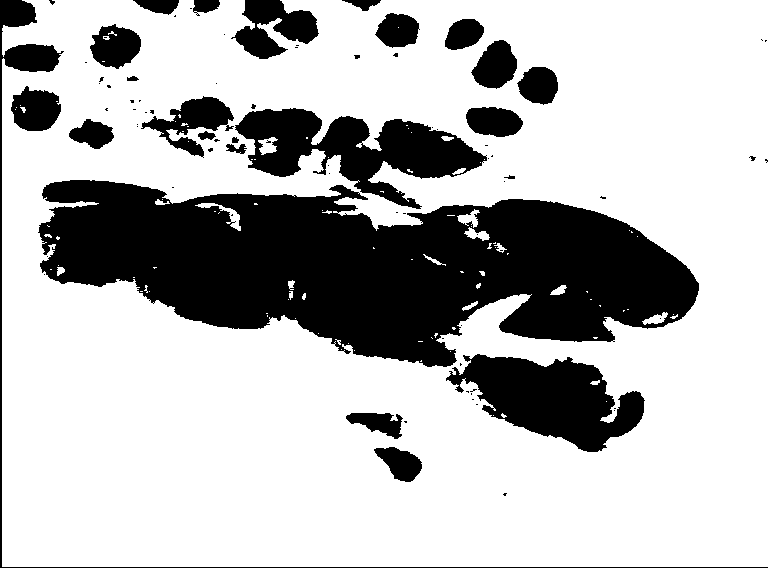

In [107]:
to_image(hist_thresh(open_in_gray("Cancerous cell smears/mod02.BMP")))

Dilation and erosion operators

In [109]:
def dilate(img, weights):
    # use a square filter with 0 for negative (white) and 1 for positive (black)
    length = len(img)
    width = len(img[0])
    mask_radius = math.floor(len(weights) / 2)
    binary = hist_thresh(img)
    new_img = []
    for i in range(length):
        new_img.append([])
        for j in range(width):
            new_img[i].append(255)

    for i in range(length):
        for j in range(width):
            if binary[i][j] == 0:
                for m in range(-mask_radius, mask_radius + 1):
                    for n in range(-mask_radius, mask_radius + 1):
                        if weights[m+mask_radius][n+mask_radius] == 1\
                            and i + m >= 0 and i + m < length\
                            and j + n > 0 and j + n < width:
                            new_img[i+m][j+n] = 0

    return new_img

In [110]:
def erode(img, weights):
    # use a square filter with 0 for negative (white) and 1 for positive (black)
    length = len(img)
    width = len(img[0])
    mask_radius = math.floor(len(weights) / 2)
    binary = hist_thresh(img)
    new_img = []

    for i in range(length):
        new_img.append([])
        for j in range(width):
            new_img[i].append(255)

    for i in range(length):
        for j in range(width):
            present = True
            for m in range(-mask_radius, mask_radius + 1):
                for n in range(-mask_radius, mask_radius + 1):
                    if weights[m+mask_radius][n+mask_radius] == 1\
                        and i + m >= 0 and i + m < length\
                        and j + n > 0 and j + n < width:
                        if binary[i+m][j+n] != 0:
                            present = False
                            break
                if not present:
                    break
            if present:    
                new_img[i][j] = 0

    return new_img

K-means

In [154]:
def k_means(img, k, iter = 100):
    binary = hist_thresh(img)
    length = len(img)
    width = len(img[0])
    sums = [[0, 0] for _ in range(k)]
    counts = [0 for _ in range(k)]
    points = []

    for i in range(length):
        for j in range(width):
            if binary[i][j] == 0:
                points.append([i, j, 0])

    centers = [[s[0], s[1]] for s in random.sample(points, k)]
    
    for i in range(iter):
        for point in points:
            cent_dist = 500000
            closest = 0
            for m in range(k):
                dist = math.sqrt((centers[m][0] - point[0])**2 + (centers[m][1] - point[1])**2)
                if dist < cent_dist:
                    cent_dist = dist
                    closest = m
            point[2] = closest
            sums[closest][0] += point[0]
            sums[closest][1] += point[1]
            counts[closest] += 1
        
        for i in range(k):
            if counts[i] != 0:
                centers[i][0] = sums[i][0] / counts[i]
                centers[i][1] = sums[i][1] / counts[i]

    colors = list(range(0, 255, round(255/k)))
    for point in points:
        binary[point[0]][point[1]] = colors[point[2]]

    return binary

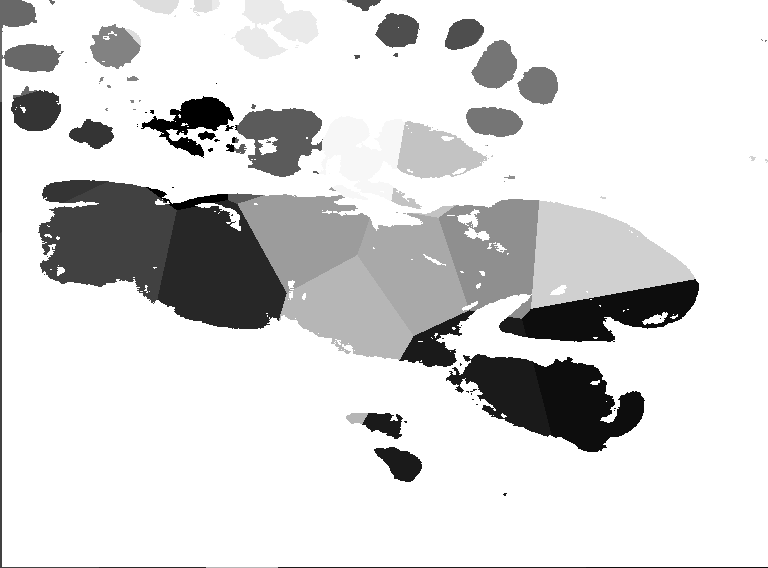

In [148]:
to_image(k_means(open_in_gray("Cancerous cell smears/mod02.BMP"), 20))